In [5]:
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from fastai.tabular.all import save_pickle, load_pickle
from src.visualization.dists import plot_pdf
from src.data import gedi_pipeline
from src.processing.recent_fires import gedi_matching, matching_analysis
import seaborn as sns
import numpy as np

sns.set_theme()

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)

2023-06-29 09:30:49,414 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-29 09:30:49,416 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-29 09:30:49,417 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.fire_perimeters' from '/home/jk871/fire-regen/src/data/fire_perimeters.py'>

### How do metrics correlate on unburned regions

In [2]:
_, gedi_unburned = gedi_pipeline.load_stage_9_B(3)

In [3]:
# Match with a corresponding NDVI
for year in range(2019, 2023):
    raster = gedi_raster_matching.get_landsat_raster_sampler(int(year))
    gedi_unburned = gedi_raster_matching.sample_raster(raster, gedi_unburned, kernel=1)
    gedi_unburned = gedi_unburned.rename(columns={"NDVI" : f"ndvi_{year}"})

In [4]:
for year in range(2019, 2023):
    gedi_unburned.loc[gedi_unburned['gedi_year'] == year, 'NDVI'] = gedi_unburned[gedi_unburned['gedi_year'] == year][f"ndvi_{year}"]

In [6]:
# Load PAI as well
gedi_l2b = pd.read_csv(f"{DATA_PATH}/sierras_gedi_l2b_shots.csv", index_col=0)
gedi_l2b_match = gedi_l2b[gedi_l2b.shot_number.isin(gedi_unburned.shot_number)]
gedi_unburned_match = gedi_unburned[gedi_unburned.shot_number.isin(gedi_l2b_match.shot_number)]
result = gedi_unburned_match.merge(gedi_l2b_match[["shot_number", "pai"]], on="shot_number")

In [7]:
save_pickle(f"{DATA_PATH}/june_29_agbd_vs_ndvi.pkl", result)

### Plot dependency

<Axes: xlabel='agbd', ylabel='NDVI'>

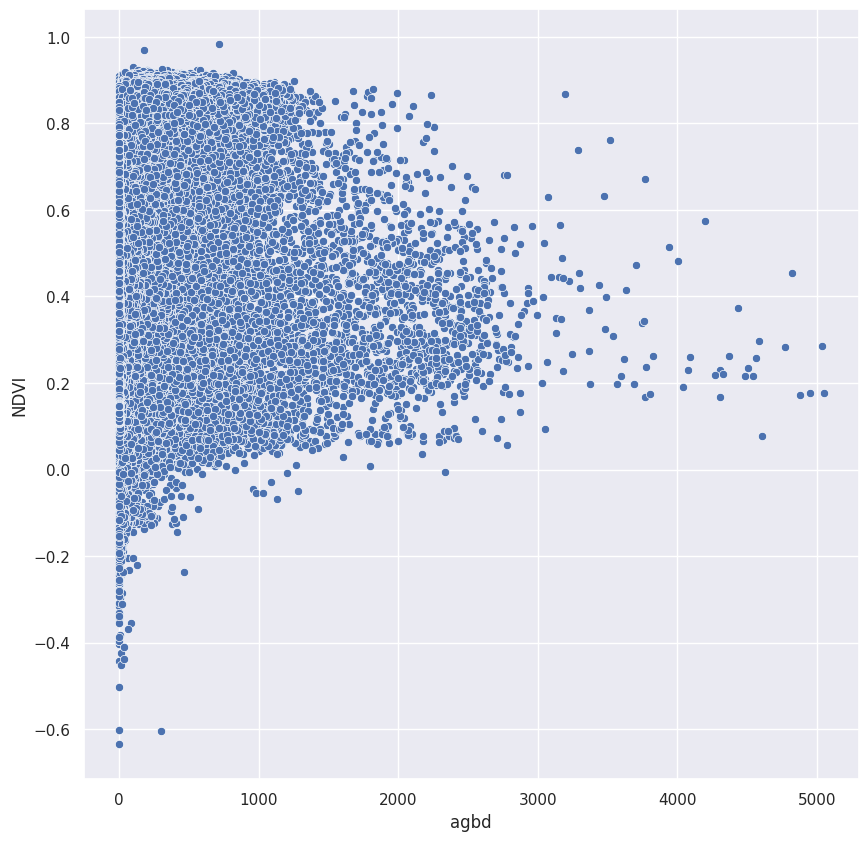

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(result, x="agbd", y="NDVI", ax=ax)

<Axes: xlabel='pai', ylabel='NDVI'>

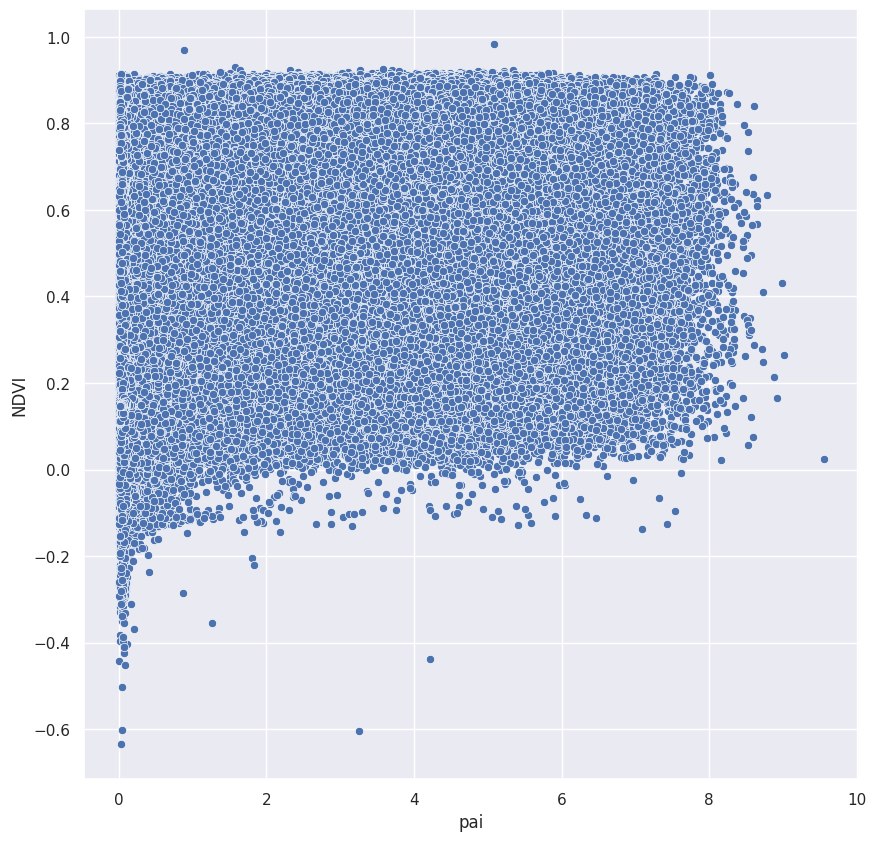

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(result[result.pai > 0], x="pai", y="NDVI", ax=ax)

In [12]:
result[result.slope < 6][["pai", "agbd", "NDVI"]].corr()

,pai,agbd,NDVI
pai,1.000000,0.624928,0.520894
agbd,0.624928,1.000000,0.469322
NDVI,0.520894,0.469322,1.000000


In [13]:
result[["pai", "agbd", "NDVI"]].corr()

,pai,agbd,NDVI
pai,1.000000,0.230095,0.173976
agbd,0.230095,1.000000,0.571806
NDVI,0.173976,0.571806,1.000000


In [14]:
result[result.pft_class==1][["pai", "agbd", "NDVI"]].corr()

,pai,agbd,NDVI
pai,1.000000,0.174285,0.101698
agbd,0.174285,1.000000,0.514641
NDVI,0.101698,0.514641,1.000000


In [15]:
result[(result.pft_class==1)&(result.slope < 6)][["pai", "agbd", "NDVI"]].corr()

,pai,agbd,NDVI
pai,1.000000,0.639842,0.461209
agbd,0.639842,1.000000,0.518811
NDVI,0.461209,0.518811,1.000000


In [22]:
result[(result.pft_class==1)&(result.slope < 20)][["pai", "agbd", "NDVI"]].corr()

,pai,agbd,NDVI
pai,1.000000,0.634555,0.414577
agbd,0.634555,1.000000,0.529837
NDVI,0.414577,0.529837,1.000000


In [23]:
result[(result.pft_class==1)&(result.slope < 20)].shape

(3109164, 35)

In [24]:
result[(result.pft_class==1)].shape

(3894296, 35)

(0.0, 20000.0)

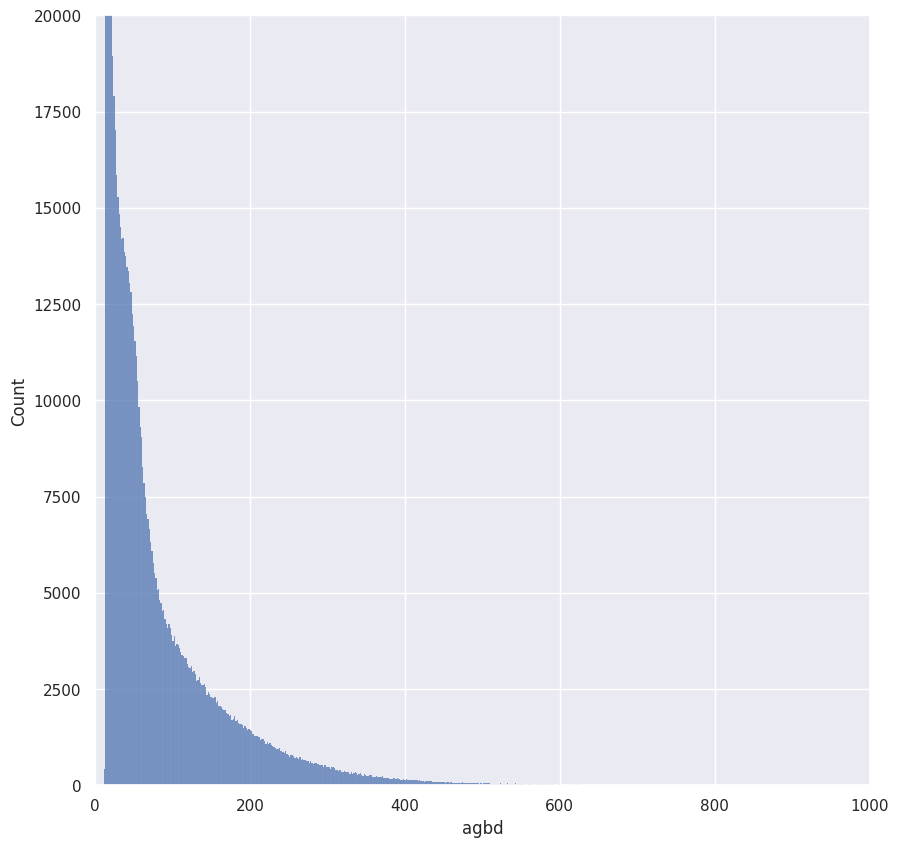

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(result[(result.slope< 6) & (result.pft_class==1)], x="agbd", ax=ax)
ax.set_xlim((0, 1000))
ax.set_ylim((0, 20000))

(0.0, 20000.0)

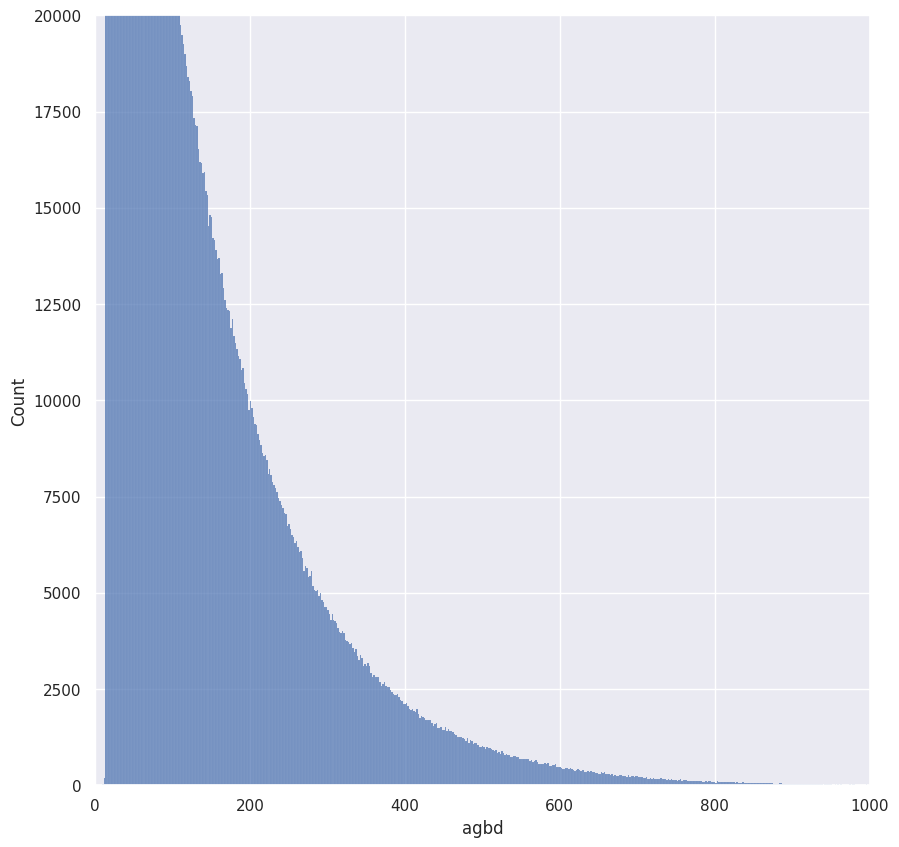

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(result[(result.slope> 6) & (result.pft_class==1)], x="agbd", ax=ax)
ax.set_xlim((0, 1000))
ax.set_ylim((0, 20000))

(0.0, 20000.0)

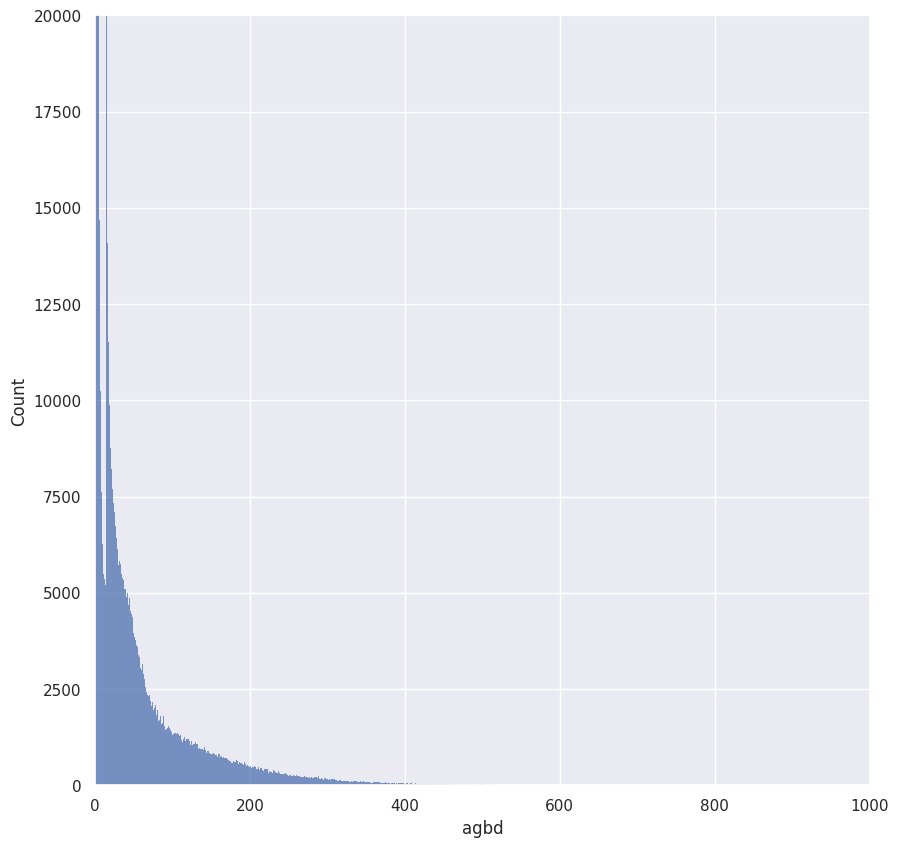

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(result[result.slope< 6], x="agbd", ax=ax)
ax.set_xlim((0, 1000))
ax.set_ylim((0, 20000))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(result[result.slope > 6], x="agbd", ax=ax)

In [ ]:
matches = gedi_matching.match_measurements_before_and_after_date("01-01-2021", gedi_unburned, 'agbd')